<a href="https://colab.research.google.com/github/novilfahlevy/UAS-Datmin-Sentiment-Analysis/blob/main/Kel_8_Sentiment_Analisys.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Analysis
<p>This collab is about to predicts comments about Pilkada DKI 2017.</p>

## Prepare functions

### Word Cloud

In [ ]:
from wordcloud import WordCloud

def cloudword(data, color):
  all_text = ' '.join(word for word in data)
  wordcloud = WordCloud(colormap=color, width=1000, height=800, mode='RGBA', background_color='white').generate(all_text)

  plt.figure(figsize=(20,10), dpi=80)
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis("off")
  plt.margins(x=0, y=0)
  plt.show()

### Text Blob (for labelling)

In [ ]:
!pip install textblob

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install translators

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from textblob import TextBlob
import translators as ts

def init_sentiment(tweet):
  try:
    translated_text = ts.translate_text(tweet, to_language='en', translator='google')
    analysis = TextBlob(translated_text)
  except:
    analysis = TextBlob(tweet)

  if analysis.sentiment.polarity > 0.0:
    return 'positive'
  
  return 'negative'

### Cleaning Text

In [ ]:
import re

# cleaning text
def cleaning_text(text):
    # remove url
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    text =  url_pattern.sub(r'', text)

    # remove hashtags
    # only removing the hash # sign from the word
    text = re.sub(r'#', '', text)

    # remove mention handle user (@)
    text = re.sub(r'@[\w]*', ' ', text)

    # remove punctuation
    punctuations = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''
    for x in text.lower(): 
        if x in punctuations: 
            text = text.replace(x, " ") 
    
    # remove extra whitespace
    text = text.strip()

    # lowercase
    text = text.lower()
    return text

### Stopwords

In [ ]:
import nltk
import requests
from nltk.corpus import stopwords

nltk.download('stopwords')
nltk.download('punkt')

# CONSTRUCT STOPWORDS
rama_stopword = "https://raw.githubusercontent.com/ramaprakoso/analisis-sentimen/master/kamus/stopword.txt"
yutomo_stopword = "https://raw.githubusercontent.com/yasirutomo/python-sentianalysis-id/master/data/feature_list/stopwordsID.txt"
fpmipa_stopword = "https://raw.githubusercontent.com/onlyphantom/elangdev/master/elang/word2vec/utils/stopwords-list/fpmipa-stopwords.txt"
sastrawi_stopword = "https://raw.githubusercontent.com/onlyphantom/elangdev/master/elang/word2vec/utils/stopwords-list/sastrawi-stopwords.txt"
aliakbar_stopword = "https://raw.githubusercontent.com/onlyphantom/elangdev/master/elang/word2vec/utils/stopwords-list/aliakbars-bilp.txt"
pebahasa_stopword = "https://raw.githubusercontent.com/onlyphantom/elangdev/master/elang/word2vec/utils/stopwords-list/pebbie-pebahasa.txt"
elang_stopword = "https://raw.githubusercontent.com/onlyphantom/elangdev/master/elang/word2vec/utils/stopwords-id.txt"
nltk_stopword = stopwords.words('indonesian')

# create path url for each stopword
path_stopwords = [rama_stopword, yutomo_stopword, fpmipa_stopword, sastrawi_stopword, 
                  aliakbar_stopword, pebahasa_stopword, elang_stopword]

# combine stopwords
stopwords_l = nltk_stopword
for path in path_stopwords:
    response = requests.get(path)
    stopwords_l += response.text.split('\n')

custom_st = '''
yg yang dgn ane smpai bgt gua gwa si tu ama utk udh btw
ntar lol ttg emg aj aja tll sy sih kalo nya trsa mnrt nih
ma dr ajaa tp akan bs bikin kta pas pdahl bnyak guys abis tnx
bang banget nang mas amat bangettt tjoy hemm haha sllu hrs lanjut
bgtu sbnrnya trjadi bgtu pdhl sm plg skrg http https politik anies baswedan
prabowo subianto pilpres pilkada pemilu
'''

# create dictionary with unique stopword
st_words = set(stopwords_l)
custom_stopword = set(custom_st.split())

# result stopwords
stop_words = st_words | custom_stopword
print(f'Stopwords: {list(stop_words)[:5]}')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Stopwords: ['sebagian', 'umumnya', 'akhiri', 'bahkan', 'sementara']


In [ ]:
from nltk import word_tokenize, sent_tokenize

def remove_stopword(text, stop_words=stop_words):
    word_tokens = word_tokenize(text)
    filtered_sentence = [w for w in word_tokens if not w in stop_words]
    return ' '.join(filtered_sentence)

### Stemming & Lemmatization

In [ ]:
!pip install Sastrawi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

def stemming_and_lemmatization(text):
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    return stemmer.stem(text)

### Tokenize

In [ ]:
# tokenization
def tokenize(text):
    return word_tokenize(text)

### Preprocess

In [ ]:
# pipeline preprocess
def preprocess(text):
    # cleaning text and lowercase
    output = cleaning_text(text)

    # remove stopwords
    output = remove_stopword(output)

    # stemming and lemmatization
    output = stemming_and_lemmatization(output)

    # tokenization
    output = tokenize(output)

    return output

### Extract Features

In [ ]:
def build_freqs(tweets, ys):
    """Build frequencies.
    Input:
        tweets: a list of tweets
        ys: an m x 1 array with the sentiment label of each tweet
            (either 0 or 1)
    Output:
        freqs: a dictionary mapping each (word, sentiment) pair to its
        frequency
    """
    # Convert np array to list since zip needs an iterable.
    # The squeeze is necessary or the list ends up with one element.
    # Also note that this is just a NOP if ys is already a list.
    yslist = np.squeeze(ys).tolist()

    # Start with an empty dictionary and populate it by looping over all tweets
    # and over all processed words in each tweet.
    freqs = {}
    for y, tweet in zip(yslist, tweets):
        for word in tweet:
            pair = (word, y)
            if pair in freqs:
                freqs[pair] += 1
            else:
                freqs[pair] = 1

    return freqs

In [ ]:
def extract_features(tweet, freqs):
    '''
    Input: 
        tweet: a list of words for one tweet
        freqs: a dictionary corresponding to the frequencies of each tuple (word, label)
    Output: 
        x: a feature vector of dimension (1,3)
    '''
    
    # 3 elements in the form of a 1 x 3 vector
    x = np.zeros((1, 3)) 
    
    #bias term is set to 1
    x[0,0] = 1 
    
    # loop through each word in the list of words
    for word in tweet:
        
        # increment the word count for the positive label 1
        x[0,1] += freqs.get((word, 1.),0)
        
        # increment the word count for the negative label 0
        x[0,2] += freqs.get((word, 0.),0)
        
    assert(x.shape == (1, 3))
    return x

## Prepare Data from real-time Tweets

### Scraping

In [ ]:
!pip install git+https://github.com/JustAnotherArchivist/snscrape.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/JustAnotherArchivist/snscrape.git to /tmp/pip-req-build-6rjyf0td
  Running command git clone --filter=blob:none --quiet https://github.com/JustAnotherArchivist/snscrape.git /tmp/pip-req-build-6rjyf0td
  Resolved https://github.com/JustAnotherArchivist/snscrape.git to commit c3b216c3cb8593513a018eb3ec4fd6f18d3aba5b
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
import snscrape.modules.twitter as sntwitter

In [ ]:
scraper = sntwitter.TwitterSearchScraper('pilkada 2017')
tweet_count = 50
tweets = []
for i, tweet in enumerate(scraper.get_items()):
  tweets.append(tweet.content)
  if i == tweet_count - 1:
    break

<ipython-input-135-bbce56fdd010>:5: DeprecatedFeatureWarning: content is deprecated, use rawContent instead
  tweets.append(tweet.content)


### Describe data

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
real_tweet_df = pd.DataFrame(tweets, columns=['Text Tweet'])
real_tweet_df.head()

,Text Tweet
0,"@alfatih_ghazy @NenkMonica Aduh, masa sich hrs..."
1,"@MarahIchsan Timses, bro... \nDi Pilkada 2017 ..."
2,@HeruSup80445135 @Dennysiregar7 Pilpres 2024 t...
3,"@AT_AbdillahToha Tak ada yg menjegal,itu asums..."
4,@ekowboy2 Yg memunculkan rasialis itu Anis saa...


In [ ]:
real_tweet_df.count()

Text Tweet    50
dtype: int64

In [ ]:
real_tweet_df.isnull().sum()

Text Tweet    0
dtype: int64

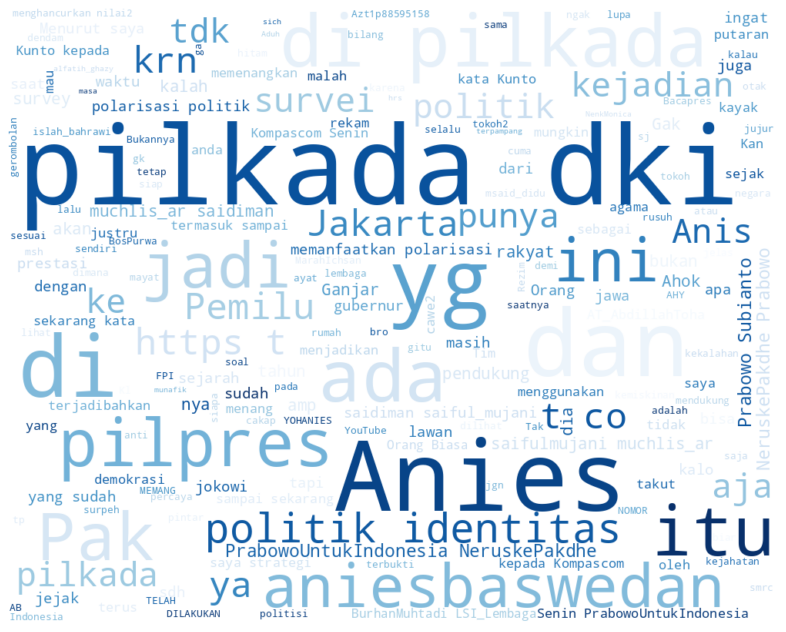

In [ ]:
cloudword(real_tweet_df['Text Tweet'], 'Blues')

### Labelling

In [ ]:
labelled_real_tweet_df = real_tweet_df.copy()
sentiments = labelled_real_tweet_df['Text Tweet'].map(init_sentiment).tolist()

labelled_real_tweet_df.insert(0, 'Sentiment', sentiments, True)

labelled_real_tweet_df.head()

,Sentiment,Text Tweet
0,positive,"@alfatih_ghazy @NenkMonica Aduh, masa sich hrs..."
1,negative,"@MarahIchsan Timses, bro... \nDi Pilkada 2017 ..."
2,negative,@HeruSup80445135 @Dennysiregar7 Pilpres 2024 t...
3,negative,"@AT_AbdillahToha Tak ada yg menjegal,itu asums..."
4,negative,@ekowboy2 Yg memunculkan rasialis itu Anis saa...


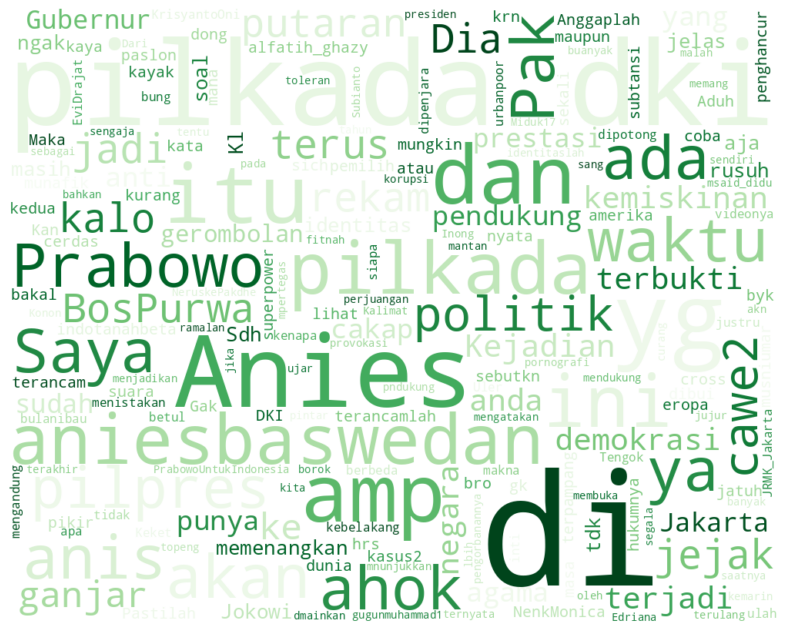

In [ ]:
positive_sentiment_df = labelled_real_tweet_df[labelled_real_tweet_df['Sentiment'] == 'positive']
cloudword(positive_sentiment_df['Text Tweet'], 'Greens')

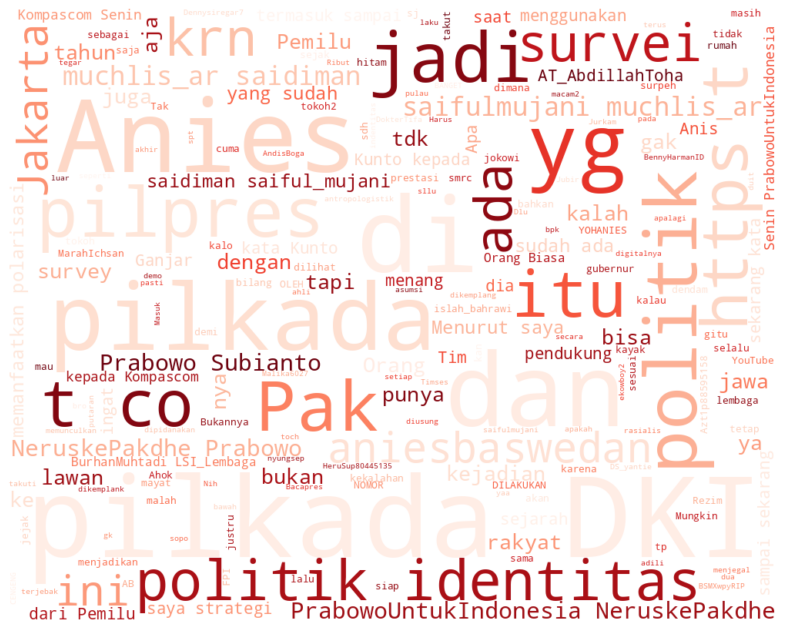

In [ ]:
negative_sentiment_df = labelled_real_tweet_df[labelled_real_tweet_df['Sentiment'] == 'negative']
cloudword(negative_sentiment_df['Text Tweet'], 'Reds')

### Preprocessing

In [ ]:
# implement preprocessing
preprocessed_real_tweet_df = labelled_real_tweet_df.copy()
preprocessed_real_tweet_df['Text Tweet'] = preprocessed_real_tweet_df['Text Tweet'].map(preprocess)

In [ ]:
preprocessed_real_tweet_df.head()

,Sentiment,Text Tweet
0,positive,"[aduh, sich, munafik, lihat, rekam, jejak, pam..."
1,negative,"[timses, 2017, tim, ahli, jurkam, jubir, 2014]"
2,negative,"[2024, tdk, jebak, indentitas, spt, dki, 2017,..."
3,negative,"[jegal, asumsi, bpk, toch, survey, 3, takut, a..."
4,negative,"[muncul, rasialis, anis, dki, 2017, jejak, dig..."


## Prepare data from CSV

In [ ]:
link_file = "https://drive.google.com/uc?id=1RW8r8P49nfuvDVgDS3lC9id0i7WgD_oC"

In [ ]:
tweet_df = pd.read_csv(link_file)

### Describe data

In [ ]:
tweet_df.head()

,Id,Sentiment,Pasangan Calon,Text Tweet
0,1,negative,Agus-Sylvi,Banyak akun kloning seolah2 pendukung #agussil...
1,2,negative,Agus-Sylvi,#agussilvy bicara apa kasihan yaa...lap itu ai...
2,3,negative,Agus-Sylvi,Kalau aku sih gak nunggu hasil akhir QC tp lag...
3,4,negative,Agus-Sylvi,Kasian oh kasian dengan peluru 1milyar untuk t...
4,5,negative,Agus-Sylvi,Maaf ya pendukung #AgusSilvy..hayo dukung #Ani...


In [ ]:
tweet_df.count()

Id                900
Sentiment         900
Pasangan Calon    900
Text Tweet        900
dtype: int64

In [ ]:
tweet_df['Sentiment'].value_counts()

negative    450
positive    450
Name: Sentiment, dtype: int64

In [ ]:
tweet_df.isnull().sum()

Id                0
Sentiment         0
Pasangan Calon    0
Text Tweet        0
dtype: int64

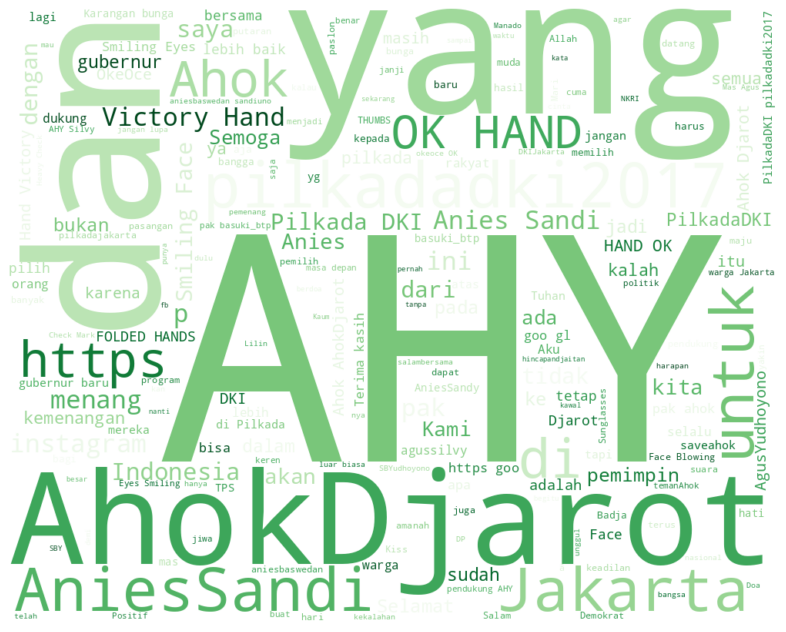

In [ ]:
positive_sentiment_df = tweet_df[tweet_df['Sentiment'] == 'positive']
cloudword(positive_sentiment_df['Text Tweet'], 'Greens')

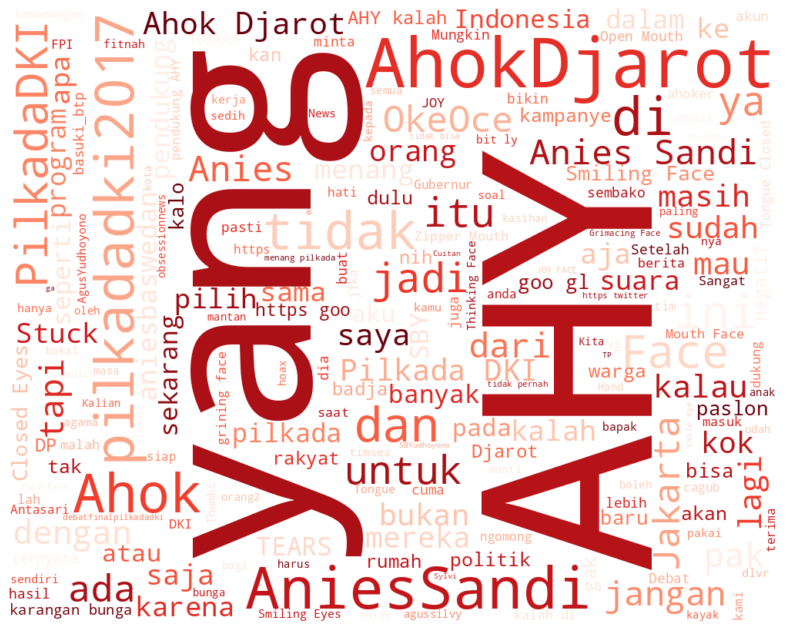

In [ ]:
negative_sentiment_df = tweet_df[tweet_df['Sentiment'] == 'negative']
cloudword(negative_sentiment_df['Text Tweet'], 'Reds')

### Drop columns

In [ ]:
tweet_df.drop(['Id', 'Pasangan Calon'], axis=1, inplace=True)
tweet_df

,Sentiment,Text Tweet
0,negative,Banyak akun kloning seolah2 pendukung #agussil...
1,negative,#agussilvy bicara apa kasihan yaa...lap itu ai...
2,negative,Kalau aku sih gak nunggu hasil akhir QC tp lag...
3,negative,Kasian oh kasian dengan peluru 1milyar untuk t...
4,negative,Maaf ya pendukung #AgusSilvy..hayo dukung #Ani...
...,...,...
895,positive,"Kali saja bpk @aniesbaswedan @sandiuno lihat, ..."
896,positive,Kita harus dapat merangkul semua orang tanpa b...
897,positive,Ini jagoanku dibidang digital <Smiling Face Wi...
898,positive,#PesanBijak #OkeOce #GubernurGu3 ...


### Preprocessing

In [ ]:
preprocessed_tweet_df = tweet_df.copy()
preprocessed_tweet_df['Text Tweet'] = preprocessed_tweet_df['Text Tweet'].map(preprocess)

In [ ]:
preprocessed_tweet_df.head()

,Sentiment,Text Tweet
0,negative,"[akun, kloning, seolah2, dukung, agussilvy, se..."
1,negative,"[agussilvy, bicara, kasihan, yaa, lap, air, ma..."
2,negative,"[gak, nunggu, qc, nunggu, motif, cuit, kayak, ..."
3,negative,"[kasi, kasi, peluru, 1milyar, rw, agussilvy, m..."
4,negative,"[maaf, dukung, agussilvy, hayo, dukung, aniess..."


## Modelling

### Encoding

In [ ]:
encoded_tweet_df = preprocessed_tweet_df.copy()
encoded_tweet_df['Sentiment'] = encoded_tweet_df['Sentiment'].map({ 'negative': 0, 'positive': 1 })
encoded_tweet_df.head()

,Sentiment,Text Tweet
0,0,"[akun, kloning, seolah2, dukung, agussilvy, se..."
1,0,"[agussilvy, bicara, kasihan, yaa, lap, air, ma..."
2,0,"[gak, nunggu, qc, nunggu, motif, cuit, kayak, ..."
3,0,"[kasi, kasi, peluru, 1milyar, rw, agussilvy, m..."
4,0,"[maaf, dukung, agussilvy, hayo, dukung, aniess..."


In [ ]:
encoded_real_tweet_df = preprocessed_real_tweet_df.copy()
encoded_real_tweet_df['Sentiment'] = encoded_real_tweet_df['Sentiment'].map({ 'negative': 0, 'positive': 1 })
encoded_real_tweet_df.head()

,Sentiment,Text Tweet
0,1,"[aduh, sich, munafik, lihat, rekam, jejak, pam..."
1,0,"[timses, 2017, tim, ahli, jurkam, jubir, 2014]"
2,0,"[2024, tdk, jebak, indentitas, spt, dki, 2017,..."
3,0,"[jegal, asumsi, bpk, toch, survey, 3, takut, a..."
4,0,"[muncul, rasialis, anis, dki, 2017, jejak, dig..."


### Prepare training and testing data

In [ ]:
train_x = encoded_tweet_df['Text Tweet']
train_y = encoded_tweet_df['Sentiment']

test_x = encoded_real_tweet_df['Text Tweet']
test_y = encoded_real_tweet_df['Sentiment']

train_x.shape, train_y.shape, test_x.shape, test_y.shape

((900,), (900,), (50,), (50,))

### Extract features

In [ ]:
# create vocabulary / dictionary frequencies
freqs = build_freqs(train_x.tolist(), train_y.tolist())

# check the output
print("type(freqs) = " + str(type(freqs)))
print("len(freqs) = " + str(len(freqs.keys())))

type(freqs) = <class 'dict'>
len(freqs) = 3087


In [ ]:
# check frequency
if ('agama', 1) in freqs: print(f"Freq dari 'agama' untuk sentiment 'positive': {freqs[('agama', 1)]}")
if ('agama', 0) in freqs: print(f"Freq dari 'agama' untuk sentiment 'positive': {freqs[('agama', 0)]}")

Freq dari 'agama' untuk sentiment 'positive': 3
Freq dari 'agama' untuk sentiment 'positive': 12


In [ ]:
# test extract features function
tmp = extract_features(train_x.to_numpy()[0], freqs)

print(f'text: {train_x.to_numpy()[0]}')
print(f'feature extraction result: {tmp}')

text: ['akun', 'kloning', 'seolah2', 'dukung', 'agussilvy', 'serang', 'paslon', 'aniessandi', 'opini', 'argumen', 'pmbenaran', 'kecoh']
feature extraction result: [[  1. 133. 160.]]


In [ ]:
# extract all of the features

# collect the features 'x' and stack them into a matrix 'X'
X_train = np.zeros((len(train_x), 3))
for i in range(len(train_x)):
    X_train[i, :]= extract_features(train_x.to_numpy()[i], freqs)

X_train[:5]

array([[  1., 133., 160.],
       [  1.,  22.,  28.],
       [  1.,  22.,  45.],
       [  1.,  16.,  27.],
       [  1., 184., 194.]])

In [ ]:
# collect the features 'x' and stack them into a matrix 'X'
X_test = np.zeros((len(test_x), 3))
for i in range(len(test_x)):
    X_test[i, :]= extract_features(test_x.to_numpy()[i], freqs)

### Training

In [ ]:
#Metrics
from sklearn.metrics import make_scorer, accuracy_score,precision_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score ,precision_score,recall_score,f1_score

#Model Select
from sklearn.model_selection import KFold,train_test_split,cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import  LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import linear_model
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB

In [ ]:
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, train_y)

RandomForestClassifier()

## Evaluation

In [ ]:
Y_prediction = random_forest.predict(X_test)

cm = confusion_matrix(test_y, Y_prediction)
accuracy = accuracy_score(test_y, Y_prediction)
precision = precision_score(test_y, Y_prediction,average='micro')
recall = recall_score(test_y, Y_prediction, average='micro')
f1 = f1_score(test_y, Y_prediction, average='micro')

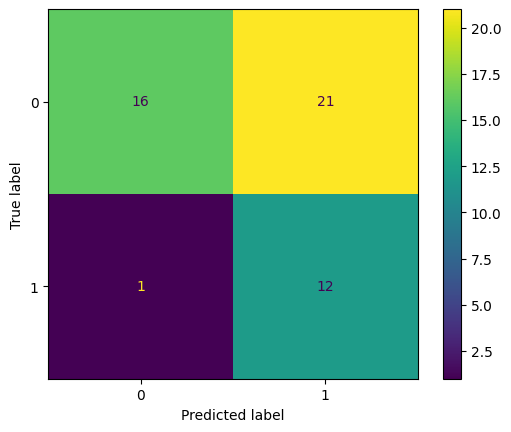

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=random_forest.classes_)
disp.plot()

In [ ]:
print('accuracy_random_Forest  : %.3f' %accuracy)
print('precision_random_Forest : %.3f' %precision)
print('recall_random_Forest    : %.3f' %recall)
print('f1-score_random_Forest  : %.3f' %f1)

accuracy_random_Forest  : 0.560
precision_random_Forest : 0.560
recall_random_Forest    : 0.560
f1-score_random_Forest  : 0.560
